In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')
sns.plotting_context(context='paper')
sns.set_palette('rainbow')

import pandas as pd

### Data prerequisites

In [56]:
# Data provided by McKinsey
sales = pd.read_csv('../../../data/mckinsey/sales.csv', index_col='ID')
skus = pd.read_csv('../../../data/mckinsey/sku.csv', index_col='SKU')
geo_params = pd.read_csv('../../../data/mckinsey/geo_params.csv', index_col='geoCluster')

sales = sales.join(skus, on='SKU')
sales = sales.join(geo_params, on='geoCluster')

sales['date'] = pd.to_datetime(sales['date'])

sales_grouped = sales.groupby(['cityId', 'Group', 'date'])['sales'].sum()

# Covid regulatory stringency index by Oxford working group that we avg in this case since we dont know city location
covid_response_index = pd.read_excel('../../../data/oxford/OxCGRT_timeseries_all.xlsx')
avg_covid_response = covid_response_index.select_dtypes('number').mean()
avg_covid_response.index = pd.to_datetime(avg_covid_response.index)

# Number of currently active delivery areas (geoClusters)
additional_clusters_added = sales.groupby('cityId').apply(lambda x: x.groupby('geoCluster')['date'].min()).to_frame()
additional_clusters_added['count'] = 1

currently_active_delivery_areas = additional_clusters_added.groupby(level=0).apply(lambda x: x.groupby('date').sum().reindex(
    pd.date_range(additional_clusters_added['date'].min(), additional_clusters_added['date'].max()),
    fill_value=0).cumsum())

# Product pricing history
sales['price'] = sales['price'].replace(0, float('nan'))

# Normalise product prices that every product in a group has the same influence on the group price signal
product_min_max_prices = sales.groupby('cityId').apply(lambda x: x.groupby('SKU')['price'].agg([min, max]))
sales_price_normalised = sales.join(product_min_max_prices, on=['cityId', 'SKU']).copy()
sales_price_normalised['price'] = sales_price_normalised['price'] - sales_price_normalised['min']
sales_price_normalised['price'] = sales_price_normalised['price'] / (sales_price_normalised['max'] - sales_price_normalised['min'])
group_price_histories_normalised = sales_price_normalised.groupby('cityId').apply(
    lambda x: x.groupby(['Group', 'date'])['price'].mean().fillna(method='ffill')
)

#### City 0

<AxesSubplot:xlabel='date'>

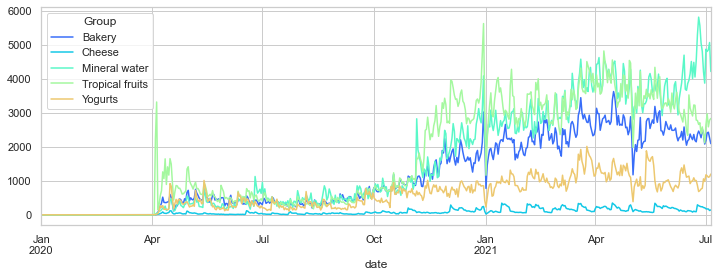

In [57]:
sales_grouped.xs(0, level=0).unstack(level=0).plot(figsize=(12, 4))

#### City 1

<AxesSubplot:xlabel='date'>

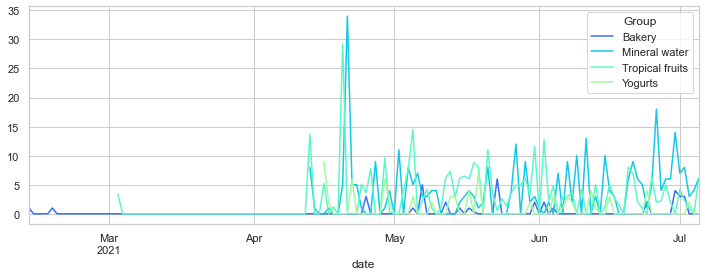

In [58]:
sales_grouped.xs(1, level=0).unstack(level=0).plot(figsize=(12, 4))

#### City 25

<AxesSubplot:xlabel='date'>

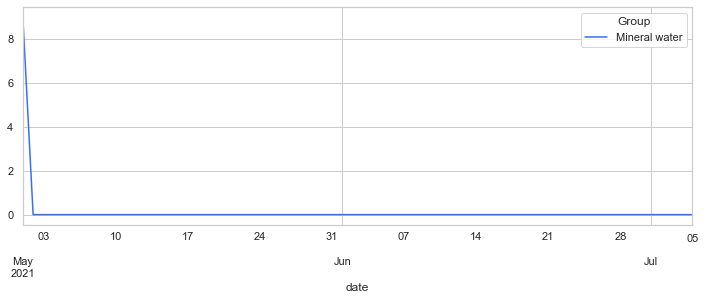

In [59]:
sales_grouped.xs(25, level=0).unstack(level=0).plot(figsize=(12, 4))

# Focus on City 0

We want to build a sales model for every product group (products that could substitute each other).

In [76]:
sales_city0 = sales_grouped.xs(0, level=0).unstack(level=0)

# Only using data from April 2020 since most delivery areas were probably introduced then
sales_city0 = sales_city0.loc['2020-04-01':]

In [113]:
# Building a sales model for each product group

import neuralprophet

models = dict()

for product_group in sales_city0.columns.to_list():

    m = neuralprophet.NeuralProphet()

    # Training sales are all sales in that city for that product group
    training_sales = sales_city0[product_group].copy().reset_index()

    training_sales.rename(columns={'date': 'ds', product_group: 'y'}, inplace=True)

    # Adding general covid reguation stringency as additional regressor that informs e-commerce buying behaviour
    training_sales = training_sales.join(avg_covid_response.rename('covid_regulatory_stringency'), on='ds')
    m.add_future_regressor('covid_regulatory_stringency')

    # Adding number of currently active delivery areas as additional regressor that informs e-commerce buying behaviour
    training_sales = training_sales.join(currently_active_delivery_areas.xs(0, level=0).squeeze().rename('currently_active_delivery_areas'), on='ds')
    m.add_future_regressor('currently_active_delivery_areas')

    # Adding relative group pricing
    training_sales = training_sales.join(group_price_histories_normalised.loc[(0, product_group)].rename('group_price_normalised'), on='ds')
    m.add_future_regressor('group_price_normalised')

    # Add US holidays as additional regressor that informs e-commerce buying behaviour (US obvsly. not necessarily applicaple)
    m.add_country_holidays(country_name='US', lower_window=-2, upper_window=2)

    # Training the NeuralProphet model for this product group and City 0
    m.fit(training_sales)

    models[product_group] = {
        'model': m,
        'training_set': training_sales
    }

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.forecaster.__handle_missing_data) - Dropped 1 rows at end due to missing future regressor values.
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\forecaster.py:1388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column], remaining_na = df_utils.fill_linear_then_rolling_avg(

INFO - (NP.forecaster.__handle_missing_data) - 3 NaN values in column group_price_normalised were auto-imputed.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dat

  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.38E-02, min: 2.03E+00


  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.38E-02, min: 2.03E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.89E-02
Epoch[254/254]: 100%|██████████| 254/254 [00:13<00:00, 18.35it/s, SmoothL1Loss=0.00218, MAE=123, RMSE=179, RegLoss=0]    
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.forecaster.__handle_missing_data) - Dropped 1 rows at end due to missing future regressor values.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.s

  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 8.38E-02, min: 1.70E-01


  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.02E-02, min: 1.70E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.38E-02
Epoch[254/254]: 100%|██████████| 254/254 [00:12<00:00, 19.70it/s, SmoothL1Loss=0.00982, MAE=27.4, RMSE=37.1, RegLoss=0]
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.forecaster.__handle_missing_data) - Dropped 1 rows at end due to missing future regressor values.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set

  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.00E+00, min: 1.43E+00


  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 4.92E-02, min: 1.19E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.70E-01
Epoch[254/254]: 100%|██████████| 254/254 [00:14<00:00, 17.29it/s, SmoothL1Loss=0.00254, MAE=212, RMSE=296, RegLoss=0]     
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.forecaster.__handle_missing_data) - Dropped 1 rows at end due to missing future regressor values.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.

  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.19E-01, min: 3.46E+00


  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.19E-01, min: 2.42E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.13E-01
Epoch[254/254]: 100%|██████████| 254/254 [00:17<00:00, 14.18it/s, SmoothL1Loss=0.00333, MAE=221, RMSE=317, RegLoss=0]     
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as D
INFO - (NP.forecaster.__handle_missing_data) - Dropped 1 rows at end due to missing future regressor values.
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.

  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.02E-02, min: 2.42E+00


  0%|          | 0/118 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.02E-02, min: 2.89E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.90E-02
Epoch[254/254]: 100%|██████████| 254/254 [00:15<00:00, 16.14it/s, SmoothL1Loss=0.00512, MAE=103, RMSE=143, RegLoss=0]  


## Predicting future group demand for City 0

In [151]:
groups = sales_grouped.xs(0, level=0).index.get_level_values(level=0).unique().to_list()

INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.df_utils._infer_frequency) - Major frequency D corresponds to 99.783% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - D
INFO - (NP.forecaster.__handle_missing_data) - Dropped 1 rows at end due to missing future regressor values.
WARNING - (py.warnings._showwarnmsg) - C:\Users\Linus Folkerts\.conda\envs\hackupc-demand-forecasting\lib\site-packages\neuralprophet\forecaster.py:1388: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, column], remaining_na = df_utils.fill_linear_then_rolling_avg(

INFO 

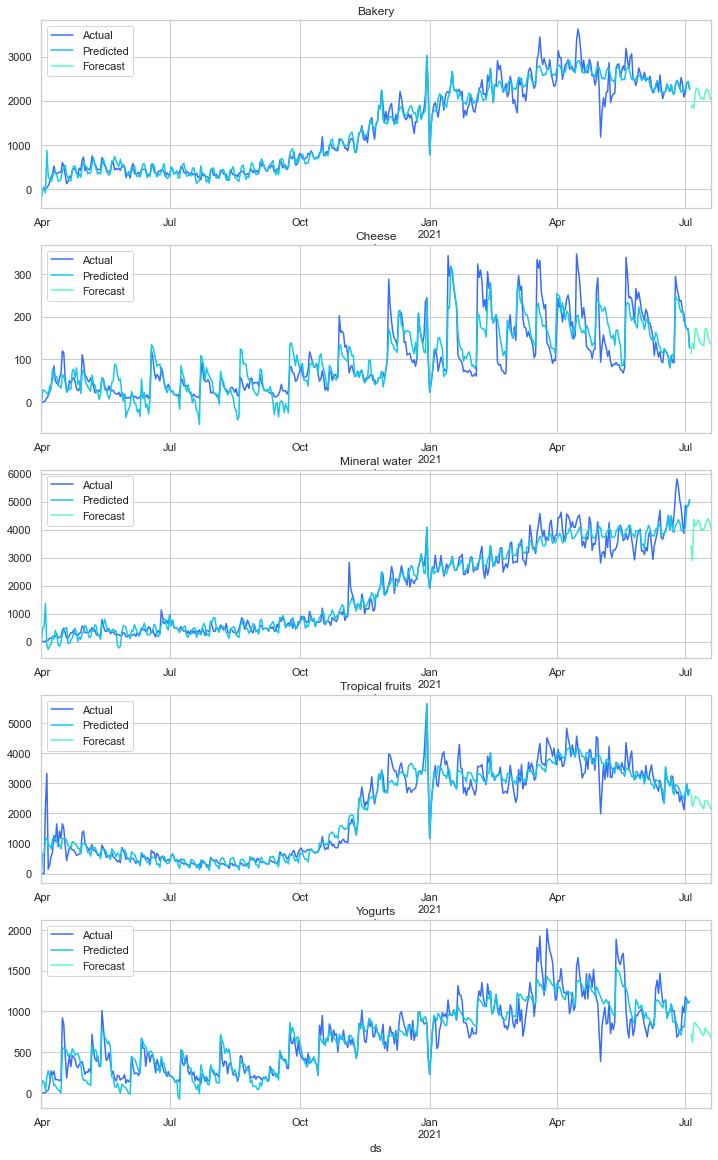

In [154]:
fig, axes = plt.subplots(len(groups), figsize=(12, 4 * len(groups)))

# Make predictions
for group, ax in zip(groups, axes):
    prediction = models[group]['model'].predict(models[group]['training_set'])
    prediction_set = models[group]['training_set'].copy()

    forecasting_set = pd.DataFrame({'ds': pd.date_range(prediction_set['ds'].max(), periods=15)})
    forecasting_set['y'] = float('nan')
    forecasting_set['covid_regulatory_stringency'] = prediction_set['covid_regulatory_stringency'].iloc[-1]
    forecasting_set['currently_active_delivery_areas'] = prediction_set['currently_active_delivery_areas'].iloc[-2]
    forecasting_set['group_price_normalised'] = prediction_set['group_price_normalised'].iloc[-1]

    forecast = models[group]['model'].predict(forecasting_set)

    # Plot actual data, prediction and forecast
    ax.set_title(group)
    prediction.plot(ax=ax, x='ds', y=['y', 'yhat1'])
    forecast.plot(ax=ax, x='ds', y='yhat1')
    ax.legend(['Actual', 'Predicted', 'Forecast'])

## P